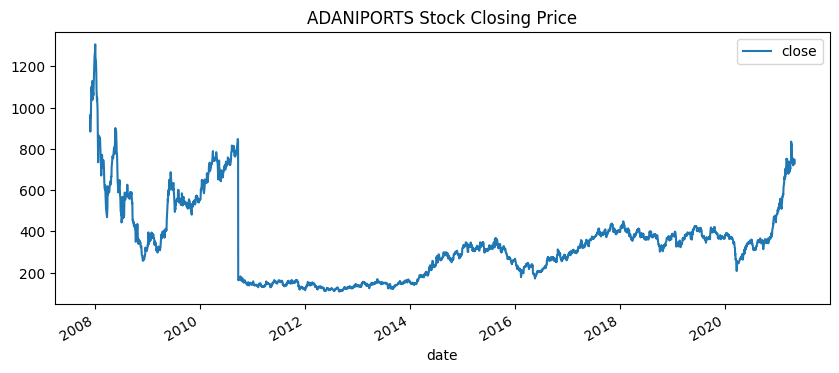

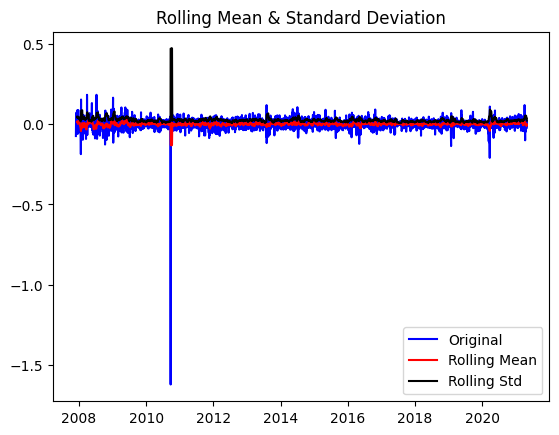

Results of Dickey-Fuller Test:
Test Statistic                  -57.220080
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    3320.000000
Critical Value (1%)              -3.432321
Critical Value (5%)              -2.862411
Critical Value (10%)             -2.567234
dtype: float64


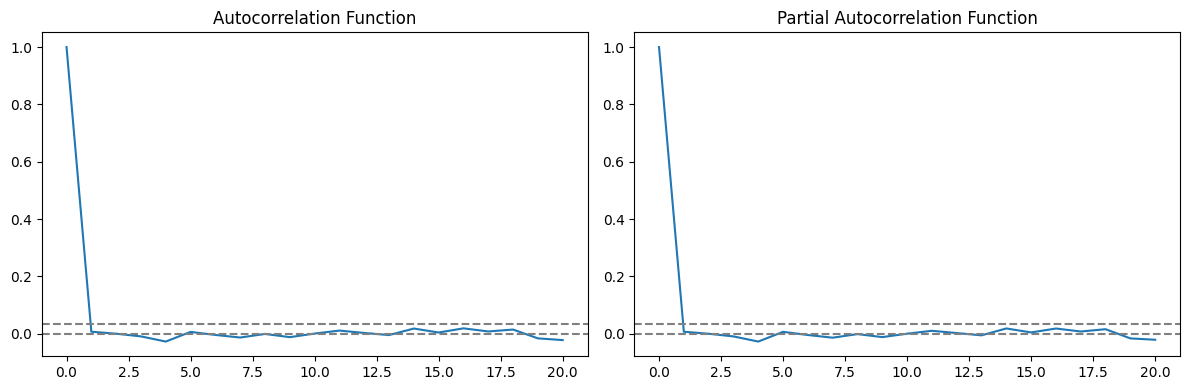

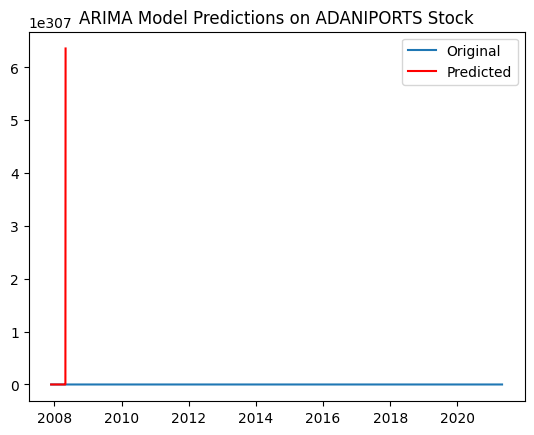

14-Day Forecast:
3322    729.933193
3323    729.923200
3324    729.922345
3325    729.922272
3326    729.922266
3327    729.922265
3328    729.922265
3329    729.922265
3330    729.922265
3331    729.922265
3332    729.922265
3333    729.922265
3334    729.922265
3335    729.922265
Name: predicted_mean, dtype: float64


In [2]:
#!/usr/bin/env python
# coding: utf-8

# Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# ARIMA-related imports
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

# Load dataset
df = pd.read_csv('ADANIPORTS.csv')
df.columns = df.columns.str.strip()  # Clean column names

# Prepare time series data
df1 = df[['Date', 'Close']]
df1.columns = ['date', 'close']
df_ts = df1.set_index('date')
df_ts.index = pd.to_datetime(df_ts.index)
df_ts.sort_index(inplace=True)
df_ts['close'].fillna(method='pad', inplace=True)

# Plot original data
df_ts.plot(title="ADANIPORTS Stock Closing Price", figsize=(10, 4))
plt.show()

# Stationarity test function
def test_stationarity(timeseries):
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()

    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(movingAverage, color='red', label='Rolling Mean')
    plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput[f'Critical Value ({key})'] = value
    print(dfoutput)

# Log transform the data
ts = df_ts['close']
ts_log = np.log(ts)

# Differencing for stationarity
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff.dropna(inplace=True)

# Test stationarity
test_stationarity(ts_log_diff)

# ACF and PACF plots
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()

# Fit ARIMA model
model = ARIMA(ts_log, order=(1,1,1))
results_ARIMA = model.fit()

# Forecast back to original scale
predictions_diff = results_ARIMA.fittedvalues
predictions_diff_cumsum = predictions_diff.cumsum()
predictions_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_log = predictions_log.add(predictions_diff_cumsum, fill_value=0)
predictions = np.exp(predictions_log)

# Plot results
plt.plot(ts, label='Original')
plt.plot(predictions, label='Predicted', color='red')
plt.title('ARIMA Model Predictions on ADANIPORTS Stock')
plt.legend(loc='best')
plt.show()

# Forecast future values (next 14 days)
forecast_log = results_ARIMA.forecast(steps=14)
forecast = np.exp(forecast_log)
print("14-Day Forecast:")
print(forecast)
